import tensorflow as tf
tf.__version__

In [1]:
import numpy as np
from tensorflow.python.keras.models import model_from_json
import tensorflow as tf

np.random.seed(2016)

# import
import os
import cv2
import pickle
import glob
import math
import datetime
import pandas as pd
import tensorflow.keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # cross_validation > model_selection
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.python.keras.utils import np_utils
from numpy.random import choice
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import h5py

# 수정 코드
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2023-05-09 12:36:03.804102: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 12:36:04.010365: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-09 12:36:05.799915: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler f

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
!nvidia-smi

Tue May  9 12:36:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  CUDA GPU            On   | 00000000:86:00.0 Off |                  Off |
| N/A   32C    P0    54W / 250W |    347MiB / 23040MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  CUDA GPU            On   | 00000000:D8:00.0 Off |                  Off |
| N/A   

In [4]:
def get_im(path): # * 이미지 처리
  # Load as grayscale
  try:
    img=cv2.imread(path,0) # 0 : grayscale
    #resized=cv2.resize(img, imsize,0,0)
    return img
  except:
    print(path)
    return "X"


def load_fromfile(input_filename1): #, input_filename2): # * 경로로부터 이미지 load
  X_train=[]
  y_train=[]
  count=0
  f=open(input_filename1,'r')
  filenames=[]
  labels=[]
  for line in f:
    filename, label=line[:-1].split('\t') # alive : 0, fake : 1
    # filename='/home/younkyul/project/Data/...'+filename
    # print(filename)
    filenames.append(filename)
    cropped=get_im(filename)
    #for l in cropped:
      # X_train.append(l)
      # y_train.append(label)
    if type(cropped)==str: continue
    X_train.append(cropped)
    y_train.append(label)
    count+=1
    print(count)
  return X_train, y_train

def cache_data(data,path):
  if os.path.isdir(os.path.dirname(path)):
    file=open(path,'wb')
    pickle.dump(data,file)
    file.close()
  else:
    print('Directory doesn\'t exist')

def restore_data(path):
  data=dict()
  if os.path.isfile(path):
    file=open(path,'rb')
    data=pickle.load(file)
  return data

def save_model(model,output_dir,sensor): # * 모델 가중치 저장하기
  try: 
    if not os.path.exists(output_dir): 
      os.makedirs(output_dir) 
  except OSError: 
    print("Error: Failed to create the directory.")

  with open(os.path.join(output_dir,sensor + '_architecture.json'),'w') as fout:
    fout.write(model.to_json())
  model.save_weights(os.path.join(output_dir,sensor + '_model_weights.h5'),overwrite=True)

def read_model(input_model_dir, sensor): # * 모델 가중치 불러오기
  model=model_from_json(open(os.path.join(input_model_dir,model_sub_dir,sensor + '_architecture.json')).read())
  model.load_weights(os.path.join(input_model_dir,model_sub_dir,sensor + '_model_weights.h5'))
  return model

In [5]:
# 학습할 센서 설정
#sensor = "CrossMatch"                
#sensor = "Digital_Persona"
sensor = "GreenBit"
#sensor = "Hi_Scan"

# 경로 설정
#model_dir = '/content/Models/' + sensor  # 모델 정보 저장할 디렉토리

batch_size = 64 #128
nb_classes = 2
nb_epoch = 10 #20

nb_filters = 16 #32
nb_pool = 2
nb_conv = 3

_optimizer = Adam(learning_rate=0.001)


########################################################################################################################
    
# Train 이미지 크기 설정
if(sensor=='CrossMatch'):
  image_size1=384
  image_size2=384
elif(sensor=='Digital_Persona'):
  image_size1=192
  image_size2=192
elif(sensor=='GreenBit'):
  image_size1=192
  image_size2=192
elif(sensor=='Hi_Scan'):
  image_size1=384
  image_size2=384
imsize=(image_size1, image_size2)    

# HDF5 파일 읽기
with h5py.File('/home/work/FingerPrint/Data/HDF5/GreenBit_Train.hdf5', 'r') as hf:
    X_train = hf.get('x_train')[:]
    X_target = hf.get('x_target')[:]
    #print(X_train)
    #print("target---\n",X_target)
    #print(X_target.shape)
    
    #X_train = hf['x_train'].value
    #X_target = hf['x_target'].value

# * 모델 쌓기
model = Sequential()
model.add(Convolution2D(32, (nb_conv, nb_conv), padding='same',input_shape=(image_size1, image_size2, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool), padding='same'))

model.add(Convolution2D(32, (nb_conv, nb_conv), padding='same',input_shape=(image_size1, image_size2, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool), padding='same'))

model.add(Convolution2D(64, (nb_conv, nb_conv), padding='same',input_shape=(image_size1, image_size2, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool), padding='same'))

model.add(Convolution2D(64, (nb_conv, nb_conv), padding='same',input_shape=(image_size1, image_size2, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool), padding='same'))

#model.add(Convolution2D(128, (nb_conv, nb_conv), padding='same'))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool), padding='same'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
          
model.add(Dense(nb_classes))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=_optimizer, metrics=['accuracy'])
model.summary()

# * 모델 학습
hist = model.fit(X_train, X_target, batch_size=batch_size, epochs=nb_epoch, verbose=1)
model.compile(loss='binary_crossentropy', optimizer=_optimizer, metrics=['accuracy'])

# * 모델 평가 및 저장
score = model.evaluate(X_train, X_target, verbose=0)
print('Score: ', score)
#save_model(model, model_dir, sensor)

2023-05-09 12:36:25.160806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21629 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:86:00.0, compute capability: 7.5
2023-05-09 12:36:25.161189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21629 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:d8:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      320       
                                                                 
 module_wrapper (ModuleWrapp  (None, 192, 192, 32)     0         
 er)                                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 module_wrapper_1 (ModuleWra  (None, 96, 96, 32)       0         
 pper)                                                           
                                                        

2023-05-09 12:36:31.462023: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


499/499 [==============================] - 13s 21ms/step - loss: 0.6233 - accuracy: 0.6057
Epoch 2/10
499/499 [==============================] - 10s 21ms/step - loss: 0.3836 - accuracy: 0.8110
Epoch 3/10
499/499 [==============================] - 10s 21ms/step - loss: 0.2402 - accuracy: 0.8935
Epoch 4/10
499/499 [==============================] - 10s 21ms/step - loss: 0.1714 - accuracy: 0.9296
Epoch 5/10
499/499 [==============================] - 10s 21ms/step - loss: 0.1289 - accuracy: 0.9483
Epoch 6/10
499/499 [==============================] - 10s 21ms/step - loss: 0.1200 - accuracy: 0.9527
Epoch 7/10
499/499 [==============================] - 10s 21ms/step - loss: 0.1077 - accuracy: 0.9576
Epoch 8/10
499/499 [==============================] - 10s 21ms/step - loss: 0.0747 - accuracy: 0.9709
Epoch 9/10
499/499 [==============================] - 10s 21ms/step - loss: 0.0676 - accuracy: 0.9745
Epoch 10/10
499/499 [==============================] - 10s 21ms/step - loss: 0.0646 - accurac

In [6]:
score = model.evaluate(X_train, X_target, verbose=0)
print('Score: ', score)

Score:  [0.03656941279768944, 0.9866921305656433]


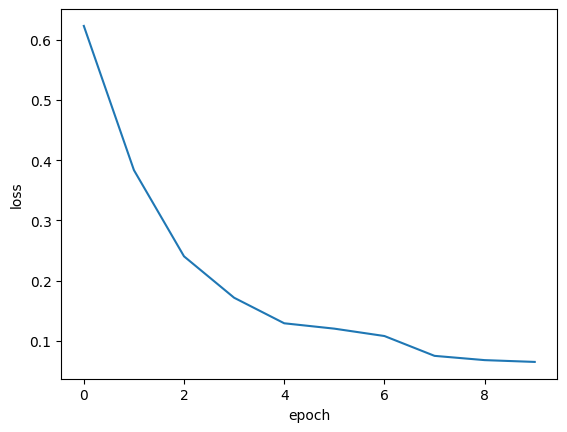

In [7]:
plt.plot(hist.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [8]:
#test data - jaeeun


#########################################################################################

# HDF5 파일 읽기
import h5py
import numpy as np
from tensorflow.keras.models import Sequential

with h5py.File('/home/work/FingerPrint/Data/HDF5/GreenBit_Test.hdf5', 'r') as hf:
    X_test = hf.get('x_test')[:]
    X_label = hf.get('x_label')[:]
    
    X_test = tf.image.resize(X_test, [192,192])
    
    #print(X_test.shape)
    X_test = X_test / 255
    
    tmp = X_label
    X_test
    X_label = []
    
#tmp에 append한 list를 저장하고, 그 list를 새로운 배열에 하나하나 저장하는 방식?
    
    trans = np.where(tmp>0,0,1)
    tmp = tmp.reshape(-1, 1)
    #print(tmp.shape)
    
    X_label = np.array(X_label)
    
    for i in tmp:
        if i==[0]:
            X_label = np.append(X_label, np.array([0., 1.]))
        else:
            X_label = np.append(X_label, np.array([1., 0.]))
            
    X_label = np.reshape(X_label, (-1, 2))
    X_label = tf.convert_to_tensor(X_label)
    
#데이터 shape 확인용    
#print(X_test)
#print(X_label.shape)
#print("-----label-----\n",X_label) 
    #어떻게 생겨머겄니?
    

#결과 도출
score = model.evaluate(X_test, X_label, verbose=0)
print('Score: ', score)

#hist = model.fit(X_test, X_label, batch_size=batch_size, epochs=nb_epoch, verbose=1)
#model.compile(loss='binary_crossentropy', optimizer=_optimizer, metrics=['accuracy'])


# * 모델 평가 및 저장

#save_model(model, model_dir, sensor)

(2495, 192, 192, 1)
(2495, 1)
Score:  [10.44753646850586, 0.36913827061653137]
